# Imports

In [1]:
!pip install -q pymc==5.15.0 pymc-bart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.7/482.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
import arviz as az
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import norm, halfcauchy
from tqdm import tqdm
import pymc as pm
import pymc_bart as pmb

# Data Preparation

In [3]:
# Load the data
data = load_diabetes(as_frame=True)
df = data.frame

# Display the data
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [4]:
# Introduce missing values for demonstration and handle them with SimpleImputer
np.random.seed(42)
df.loc[np.random.rand(df.shape[0]) < 0.1] = np.nan  # Randomly introduce missing values

# Display rows with missing values
df_with_na = df[df.isna().any(axis=1)]
display(df_with_na.head())
print("\n")

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Display the same rows after imputation
df_imputed_with_na = df_imputed[df.isna().any(axis=1)]
display(df_imputed_with_na.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
6,0.000656,0.000172,-0.000288,0.000902,0.000675,0.000628,0.000081,0.000563,0.000072,0.000848,150.724675
10,0.000656,0.000172,-0.000288,0.000902,0.000675,0.000628,0.000081,0.000563,0.000072,0.000848,150.724675
29,0.000656,0.000172,-0.000288,0.000902,0.000675,0.000628,0.000081,0.000563,0.000072,0.000848,150.724675
32,0.000656,0.000172,-0.000288,0.000902,0.000675,0.000628,0.000081,0.000563,0.000072,0.000848,150.724675
37,0.000656,0.000172,-0.000288,0.000902,0.000675,0.000628,0.000081,0.000563,0.000072,0.000848,150.724675


In [5]:
# Split the data into training and test sets
X = df_imputed.drop("target", axis=1)
y = df_imputed["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Normalize the features
X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (353, 10)
y_train shape: (353,)
X_test shape: (89, 10)
y_test shape: (89,)


# Define the Model

In [7]:
# Define and train the BART model
with pm.Model() as model:
    X_data = pm.Data("X", X_train)

    # Direct BART output, store in a separate variable
    μ_bart = pmb.BART("μ_bart", X_data, y_train, m=50)

    # Add the linear term
    α = pm.Normal("α", mu=0, sigma=1)

    # Final model output as a deterministic variable
    μ = pm.Deterministic("μ", α + μ_bart)

    σ = pm.HalfNormal("σ", sigma=1)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y_train)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.99, idata_kwargs={"log_likelihood": True})

Output()

# Trace Summary

In [8]:
# Summarize and diagnose the model
summary = az.summary(trace)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.060,1.149,-2.172,2.136,0.023,0.016,2478.0,3336.0,1.00
μ[0],199.284,13.462,174.615,224.717,0.398,0.281,1147.0,2102.0,1.02
μ[1],134.516,14.023,108.604,161.979,0.423,0.299,1104.0,1840.0,1.01
μ[2],230.780,13.932,204.968,256.956,0.402,0.284,1203.0,2350.0,1.01
μ[3],93.190,11.893,70.031,114.616,0.338,0.239,1236.0,2256.0,1.01
...,...,...,...,...,...,...,...,...,...
μ_bart[349],185.607,15.210,156.142,213.323,0.441,0.312,1189.0,1934.0,1.01
μ_bart[350],115.385,12.335,91.348,137.926,0.361,0.255,1171.0,2079.0,1.00
μ_bart[351],106.169,13.164,80.812,130.571,0.390,0.276,1138.0,2024.0,1.01
μ_bart[352],155.795,14.190,130.823,183.371,0.405,0.288,1235.0,1796.0,1.01


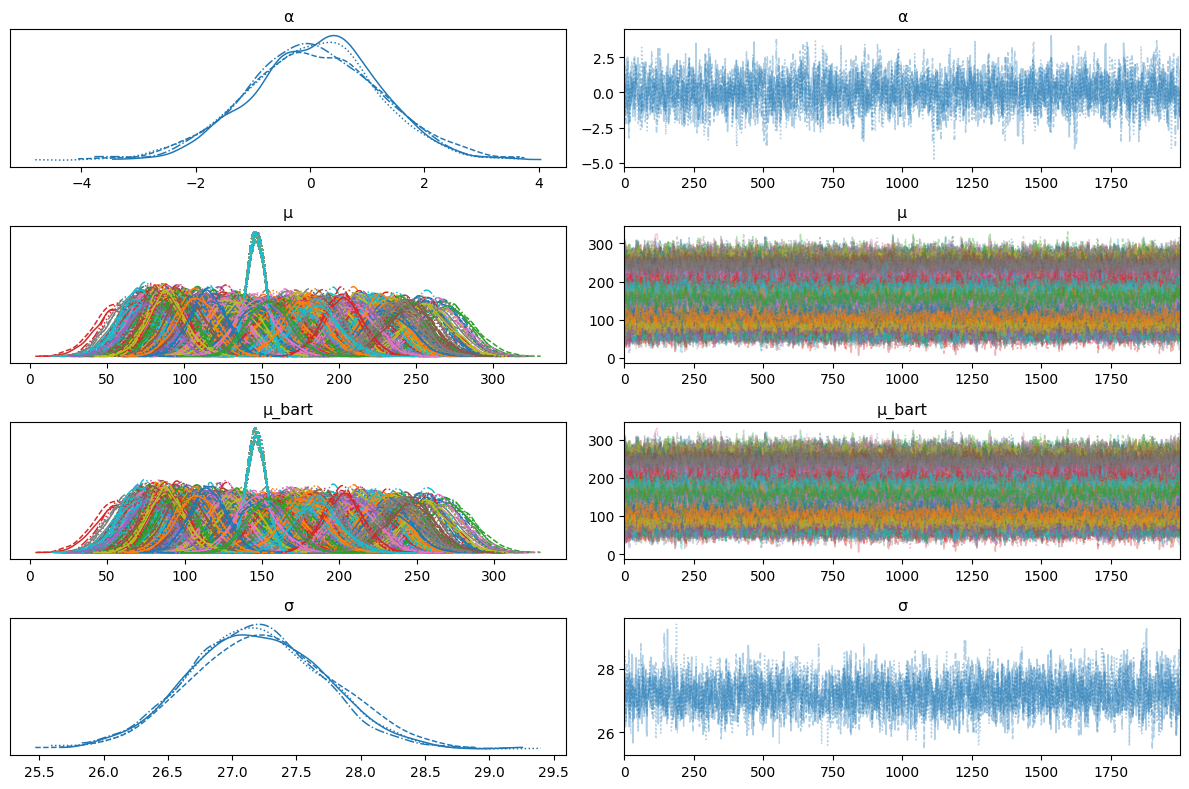

In [9]:
# Plot trace plots for diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Model Predictions

Output()

<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


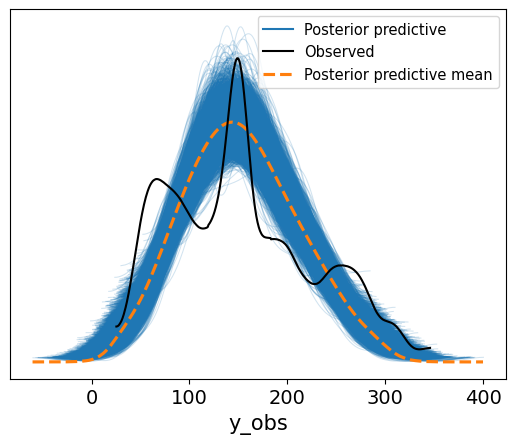

In [10]:
# Posterior predictive checks
plt.figure(figsize=(10, 6))
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])
az.plot_ppc(ppc)
plt.show()

In [11]:
# Out-of-sample predictions
with model:
    X_data.set_value(X_test)  # Update the model with new data for predictions
    ppc_test = pm.sample_posterior_predictive(trace, var_names=["μ"])

Output()

In [12]:
# Extract the mean predictions for each test instance
y_pred_mean = ppc_test.posterior_predictive['μ'].mean(dim=["chain", "draw"]).values

# Create the DataFrame
y_pred_df = pd.DataFrame(y_pred_mean, columns=['Predicted Values'])

# Display the DataFrame
display(y_pred_df.head())

,Predicted Values
0,161.800119
1,170.139124
2,146.558008
3,265.397861
4,125.686970


In [13]:
# Metrics using the mean predictions
y_pred = y_pred_df.values.ravel()
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 43.589886527205536
MAE: 33.27841651493521


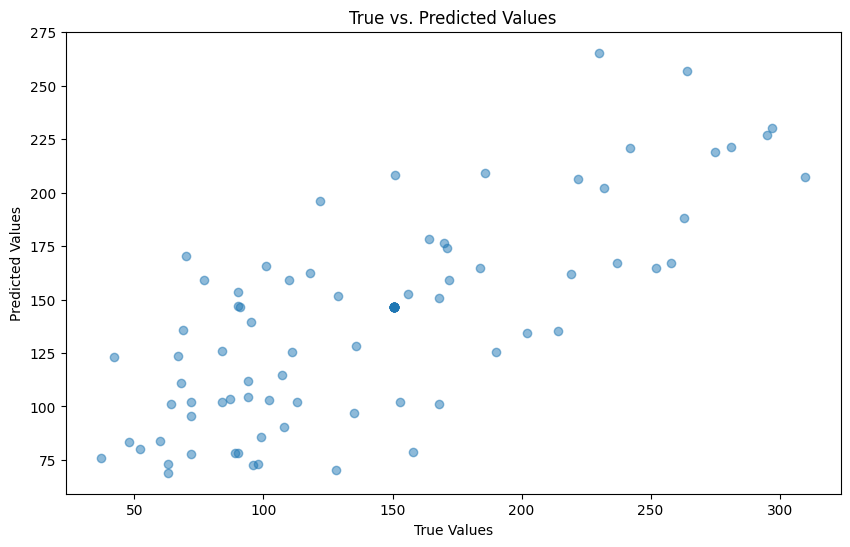

In [14]:
# Plotting true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.show()

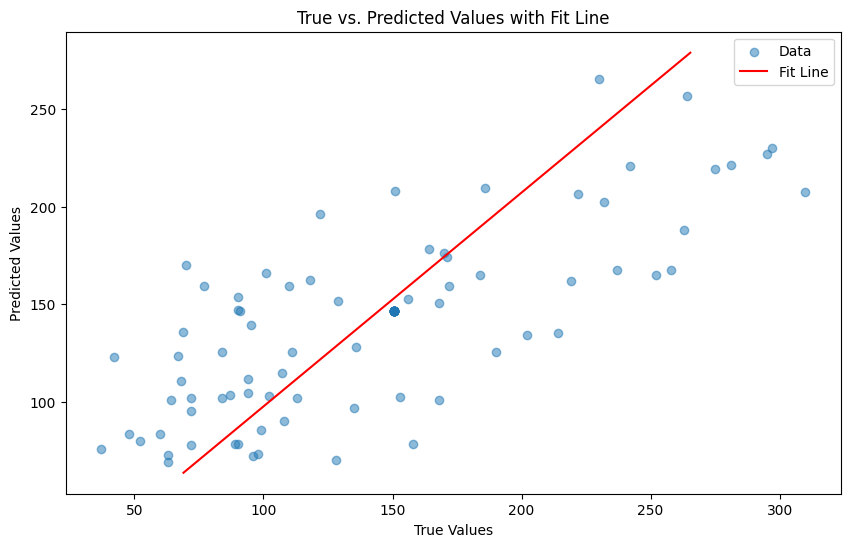

In [15]:
# Fit a linear regression model
reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test)

# Get the predicted values for the line
line_x = np.linspace(y_pred.min(), y_pred.max(), 100)
line_y = reg.predict(line_x.reshape(-1, 1))

# Plotting true vs. predicted values with the regression line
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Data")
plt.plot(line_x, line_y, color='red', label="Fit Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values with Fit Line")
plt.legend()
plt.show()

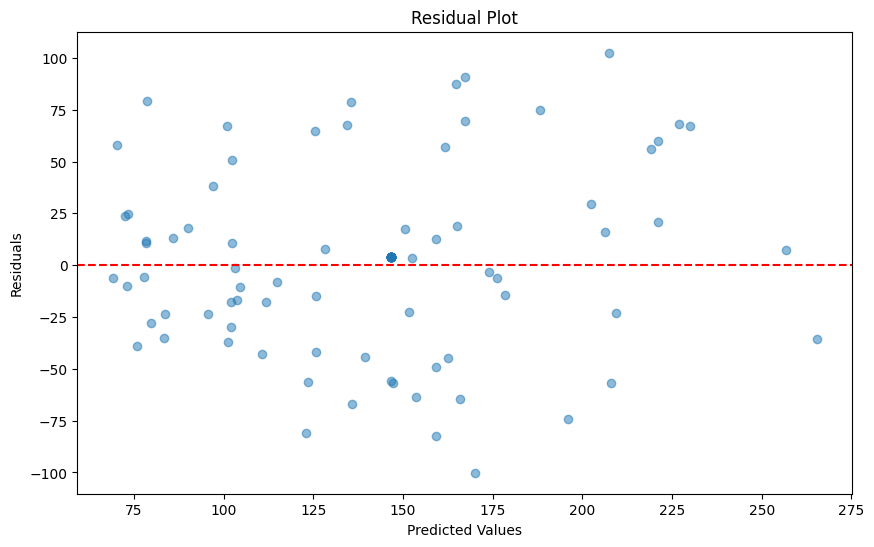

In [16]:
# Residual plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

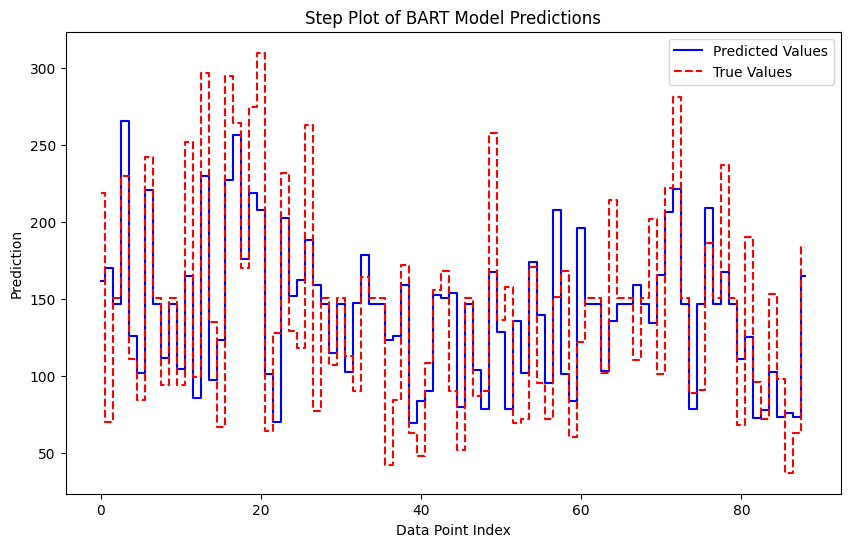

In [17]:
# Step plot for predicted values
plt.figure(figsize=(10, 6))
plt.step(range(len(y_pred)), y_pred, where='mid', label='Predicted Values', color='blue')

# Plot the true values for comparison
plt.step(range(len(y_test)), y_test, where='mid', label='True Values', color='red', linestyle='--')
plt.xlabel("Data Point Index")
plt.ylabel("Prediction")
plt.title("Step Plot of BART Model Predictions")
plt.legend()
plt.show()

# Feature Importance

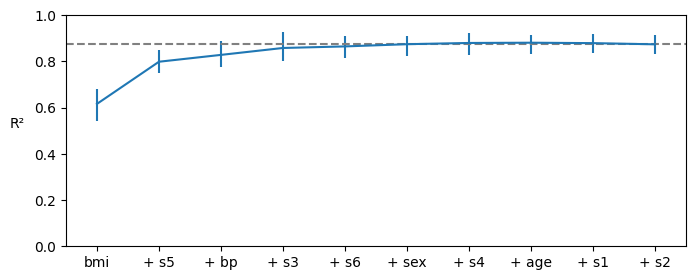

In [18]:
# Plot variable importance
pmb.plot_variable_importance(trace, μ_bart, X=X_train)
plt.show()

In [19]:
# Function to calculate permutation importance
def calculate_permutation_importance(model, X_test, y_test, trace, n_repeats=10):
    """
    Calculate permutation feature importance for a PyMC BART model.

    Parameters:
    model: PyMC model object
    X_test: Test feature data
    y_test: Test target data
    trace: Posterior trace from BART model
    n_repeats: Number of times to permute a feature

    Returns:
    DataFrame with feature importance scores
    """
    with model:
        # Make predictions for the original test set
        bart_posterior = pm.sample_posterior_predictive(trace, var_names=["μ"])
        y_pred = bart_posterior.posterior_predictive['μ'].mean(dim=["chain", "draw"]).values

    base_mse = mean_squared_error(y_test, y_pred)

    importances = []

    # Wrap the loop with tqdm for progress monitoring
    for feature in tqdm(X_test.columns, desc="Calculating feature importance"):
        # Shuffle the feature
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

        with model:
            pm.set_data({"X": X_test_permuted})  # Update the model with permuted data
            bart_posterior_permuted = pm.sample_posterior_predictive(trace, var_names=["μ"])
            y_pred_permuted = bart_posterior_permuted.posterior_predictive['μ'].mean(dim=["chain", "draw"]).values

        permuted_mse = mean_squared_error(y_test, y_pred_permuted)
        importance = permuted_mse - base_mse
        importances.append(importance)

    importance_df = pd.DataFrame({"Feature": X_test.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)

    return importance_df

Output()

Calculating feature importance:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

Calculating feature importance:  10%|█         | 1/10 [01:09<10:26, 69.62s/it]

Output()

Calculating feature importance:  20%|██        | 2/10 [02:21<09:27, 70.96s/it]

Output()

Calculating feature importance:  30%|███       | 3/10 [03:32<08:16, 70.90s/it]

Output()

Calculating feature importance:  40%|████      | 4/10 [04:41<07:02, 70.36s/it]

Output()

Calculating feature importance:  50%|█████     | 5/10 [05:50<05:49, 69.81s/it]

Output()

Calculating feature importance:  60%|██████    | 6/10 [06:59<04:38, 69.60s/it]

Output()

Calculating feature importance:  70%|███████   | 7/10 [08:09<03:28, 69.59s/it]

Output()

Calculating feature importance:  80%|████████  | 8/10 [09:18<02:19, 69.54s/it]

Output()

Calculating feature importance:  90%|█████████ | 9/10 [10:30<01:10, 70.25s/it]

Output()

Calculating feature importance: 100%|██████████| 10/10 [11:41<00:00, 70.11s/it]

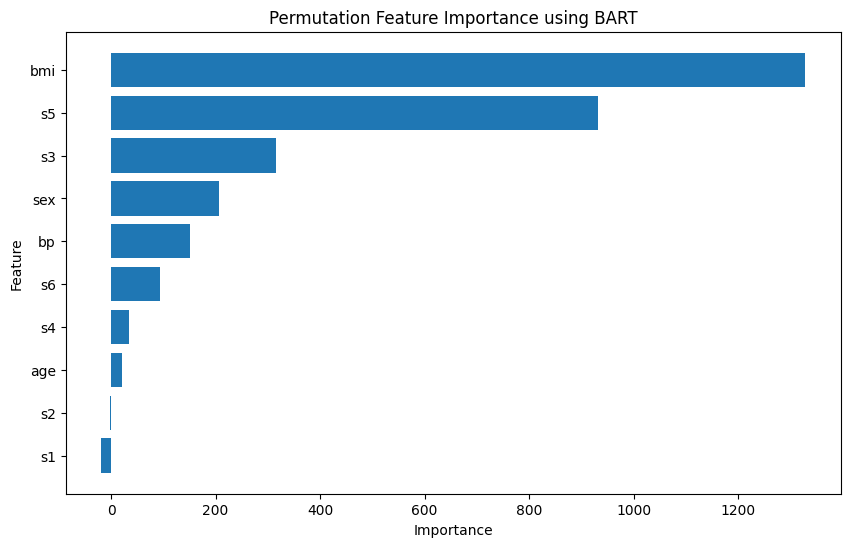

In [20]:
# Calculate feature importance
importance_df = calculate_permutation_importance(model, X_test, y_test, trace)
print("\n")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance using BART")
plt.gca().invert_yaxis()
plt.show()

# Partial Dependence

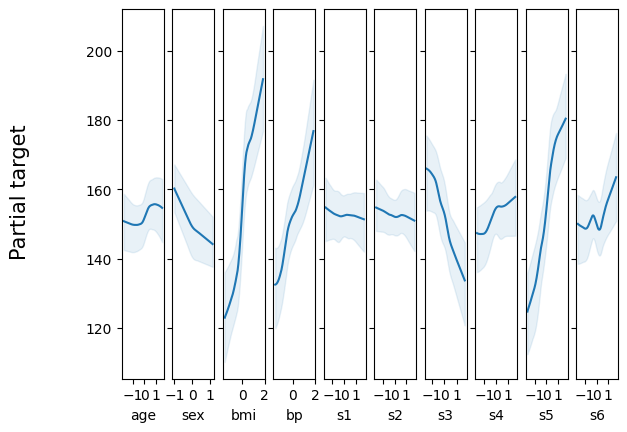

In [21]:
# Plot partial dependence plots (PDP) for selected features
pmb.plot_pdp(μ_bart, X=X_train, Y=y_train, grid='wide')
plt.show()

# Cross-Validation

In [22]:
# Function to perform cross-validation
def cross_val_bart(X, y, m=50, cv=5):
    """
    Perform k-fold cross-validation with a PyMC BART model.

    Parameters:
    X (pd.DataFrame): Feature matrix.
    y (pd.Series): Target variable.
    m (int): Number of trees in the BART model.
    cv (int): Number of cross-validation folds.

    Returns:
    float: Mean cross-validated MSE.
    """
    mse_scores = []

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        # Normalize within the fold
        X_train_mean, X_train_std = X_train_cv.mean(axis=0), X_train_cv.std(axis=0)
        X_train_cv = (X_train_cv - X_train_mean) / X_train_std
        X_test_cv = (X_test_cv - X_train_mean) / X_train_std

        with pm.Model() as model_cv:
            # Set up the data in the model
            X_data_cv = pm.Data("X_cv", X_train_cv)

            # BART model
            μ_bart_cv = pmb.BART("μ_bart_cv", X_data_cv, y_train_cv, m=m)

            # Linear term
            α_cv = pm.Normal("α_cv", mu=0, sigma=1)

            # Final model output as a deterministic variable
            μ_cv = pm.Deterministic("μ_cv", α_cv + μ_bart_cv)

            # Likelihood
            σ_cv = pm.HalfNormal("σ_cv", sigma=1)
            y_obs_cv = pm.Normal("y_obs_cv", mu=μ_cv, sigma=σ_cv, observed=y_train_cv)

            trace_cv = pm.sample(1000, tune=500, return_inferencedata=True, progressbar=True, idata_kwargs={"log_likelihood": True})

        # Out-of-sample predictions using the trained model
        with model_cv:
            pm.set_data({"X_cv": X_test_cv})  # Update the model with the test data
            ppc_cv = pm.sample_posterior_predictive(trace_cv, var_names=["μ_cv"], progressbar=True)

            # Extract the mean predictions for each test instance
            y_pred_cv = ppc_cv.posterior_predictive['μ_cv'].mean(dim=["chain", "draw"]).values

        # Evaluate the performance
        mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
        mse_scores.append(mse_cv)

    return np.mean(mse_scores)

In [23]:
# Perform cross-validation
cv_mse = cross_val_bart(X_train, y_train, m=50, cv=5)
print(f"Cross-Validated Mean Squared Error: {cv_mse}")

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Cross-Validated Mean Squared Error: 2631.690150699173


In [24]:
# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder to store the results
waic_scores = []
loo_scores = []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Normalize the features for cross-validation fold
    X_train_mean, X_train_std = X_train_cv.mean(axis=0), X_train_cv.std(axis=0)
    X_train_cv = (X_train_cv - X_train_mean) / X_train_std
    X_test_cv = (X_test_cv - X_train_mean) / X_train_std

    # Fit the BART model on the current fold
    with pm.Model() as model_cv:
        # Set up the data in the model
        X_data_cv = pm.Data("X_cv", X_train_cv)

        # BART model
        μ_bart_cv = pmb.BART("μ_bart_cv", X_data_cv, y_train_cv, m=50)

        # Linear term
        α_cv = pm.Normal("α_cv", mu=0, sigma=1)

        # Final model output as a deterministic variable
        μ_cv = pm.Deterministic("μ_cv", α_cv + μ_bart_cv)

        # More robust prior for σ
        σ_cv = pm.HalfCauchy("σ_cv", beta=1)
        y_obs_cv = pm.Normal("y_obs_cv", mu=μ_cv, sigma=σ_cv, observed=y_train_cv)

        # Sample from the posterior, including log-likelihood
        trace_cv = pm.sample(
            2000,
            tune=1000,
            return_inferencedata=True,
            target_accept=0.99,
            idata_kwargs={"log_likelihood": True}
        )

        # Compute WAIC and LOO for this fold
        waic_cv = az.waic(trace_cv)
        loo_cv = az.loo(trace_cv)

        waic_scores.append(waic_cv)
        loo_scores.append(loo_cv)

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [25]:
# View the WAIC scores list object
waic_scores

[Computed from 8000 posterior samples and 353 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -1888.88    13.74
 p_waic       29.78        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 8000 posterior samples and 353 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -1880.26    13.91
 p_waic       30.72        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 8000 posterior samples and 354 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -1875.84    14.18
 p_waic       34.01        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 8000 posterior samples and 354 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -1887.78    13.91
 p_waic       34.87        -
 
 There has been a warning during the calculation. Please check the results.,


In [26]:
# View the LOO scores list object
loo_scores

[Computed from 8000 posterior samples and 353 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -1889.17    13.77
 p_loo       30.08        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      353  100.0%
  (0.5, 0.7]   (ok)          0    0.0%
    (0.7, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 Computed from 8000 posterior samples and 353 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -1880.57    13.94
 p_loo       31.04        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      353  100.0%
  (0.5, 0.7]   (ok)          0    0.0%
    (0.7, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 Computed from 8000 posterior samples and 354 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -1876.27    14.22
 p_loo       34.44        -
 ------
 
 Pareto k diagno

In [27]:
# Extract and average the WAIC scores
average_waic = np.mean([waic["elpd_waic"] for waic in waic_scores])

# Extract and average the LOO scores
average_loo = np.mean([loo["elpd_loo"] for loo in loo_scores])

print(f"Average WAIC: {average_waic}")
print(f"Average LOO-CV: {average_loo}")

Average WAIC: -1883.657708774042
Average LOO-CV: -1884.0373357484714


# Model Comparison

In [28]:
# Define the linear regression model
with pm.Model() as linear_model:
    X_data = pm.Data("X", X_train)
    y_data = pm.Data("y", y_train)

    # Priors for the coefficients (beta) and intercept (alpha)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X_train.shape[1])

    # Linear model
    mu = pm.Deterministic("mu", alpha + pm.math.dot(X_data, beta))

    # Prior for the standard deviation of the observations
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    # Inference: sampling from the posterior, including log-likelihood
    trace_lr = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.99, idata_kwargs={"log_likelihood": True})

# Summary of the trace
az.summary(trace_lr)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,18.112,0.987,16.290,20.004,0.011,0.008,8315.0,6413.0,1.0
beta[0],1.123,0.935,-0.554,2.925,0.009,0.008,10143.0,6206.0,1.0
beta[1],-0.379,0.945,-2.165,1.362,0.009,0.010,10894.0,5893.0,1.0
beta[2],4.348,0.942,2.583,6.089,0.009,0.007,10380.0,6229.0,1.0
beta[3],3.171,0.933,1.478,4.964,0.010,0.007,9162.0,6457.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[349],22.427,2.782,17.060,27.441,0.029,0.020,9378.0,5289.0,1.0
mu[350],7.421,2.400,2.979,12.020,0.022,0.017,11904.0,5863.0,1.0
mu[351],7.485,2.046,3.731,11.359,0.019,0.014,11736.0,5973.0,1.0
mu[352],12.099,3.007,6.430,17.713,0.029,0.021,10521.0,5999.0,1.0


In [29]:
import warnings

# Suppress specific warnings from arviz and numpy
warnings.filterwarnings("ignore", category=UserWarning, message=".*posterior variance of the log predictive densities exceeds*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Estimated shape parameter of Pareto distribution is greater than*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*overflow encountered in exp.*")

In [30]:
# Compute WAIC for both models
waic_bart = az.waic(trace)
waic_lr = az.waic(trace_lr)

# Compute LOO-CV for both models
loo_bart = az.loo(trace)
loo_lr = az.loo(trace_lr)

# Print the results
print(f"BART Model - WAIC: {waic_bart['elpd_waic']}, LOO-CV: {loo_bart['elpd_loo']}")
print(f"Linear Regression Model - WAIC: {waic_lr['elpd_waic']}, LOO-CV: {loo_lr['elpd_loo']}")

BART Model - WAIC: -2208.4578911098033, LOO-CV: -2228.3801523808206
Linear Regression Model - WAIC: -3208.8337650504154, LOO-CV: -3208.8464444046294


In [31]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["BART", "Linear Regression"],
    "WAIC": [waic_bart['elpd_waic'], waic_lr['elpd_waic']],
    "LOO-CV": [loo_bart['elpd_loo'], loo_lr['elpd_loo']]
})

# Display the DataFrame
display(results_df)

,Model,WAIC,LOO-CV
0,BART,-2208.457891,-2228.380152
1,Linear Regression,-3208.833765,-3208.846444


In [32]:
# Perform model comparison
model_comparison = az.compare({"BART": trace, "Linear Regression": trace_lr}, method='stacking')

# Display the comparison table
display(model_comparison)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
BART,0,-2228.380152,304.429412,0.000000,0.893242,53.028945,0.000000,True,log
Linear Regression,1,-3208.846444,12.995101,980.466292,0.106758,69.388317,72.976256,False,log


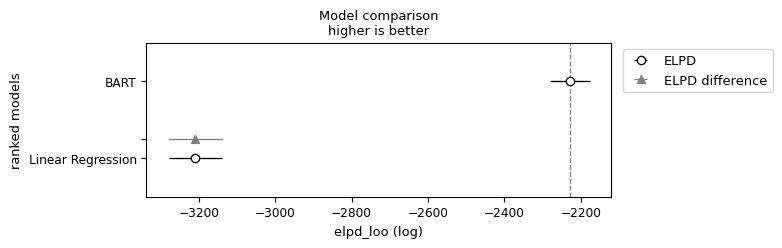

In [33]:
# Visualize the comparison
az.plot_compare(model_comparison)
plt.show()

In [34]:
# Extract and display Pareto k diagnostic values for each model
loo_bart = az.loo(trace)
loo_lr = az.loo(trace_lr)

pareto_k_bart = loo_bart.pareto_k.values
pareto_k_lr = loo_lr.pareto_k.values

pareto_k_df = pd.DataFrame({
    "Model": ["BART", "Linear Regression"],
    "Pareto_k_mean": [pareto_k_bart.mean(), pareto_k_lr.mean()],
    "Pareto_k_max": [pareto_k_bart.max(), pareto_k_lr.max()]
})

print("Pareto k Diagnostic Values:")
display(pareto_k_df)

Pareto k Diagnostic Values:


,Model,Pareto_k_mean,Pareto_k_max
0,BART,0.456218,1.272793
1,Linear Regression,-0.019865,0.260473
